In [1]:
# import numpy as np
import autograd.numpy as np
from autograd import grad, jacobian
import autograd.numpy.random as npr

from matplotlib import pyplot as plt
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib inline
import itertools

In [5]:
x = np.random.normal(size=(3000,3000))
y = np.random.normal(size=(3000,3000))

z = np.matmul(x,y)

In [3]:
def analytic_solution(x):
    return (1 / (np.exp(np.pi) - np.exp(-np.pi))) * \
            np.sin(np.pi * x[0]) * (np.exp(np.pi * x[1]) - np.exp(-np.pi * x[1]))

def f(x):
    return 0.

def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def neural_network(W, x):
    a1 = sigmoid(np.dot(x, W[0]))
    return np.dot(a1, W[1])

def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

def neural_network(W, x):
    a1 = sigmoid(np.dot(x, W[0]))
    return np.dot(a1, W[1])

def d_neural_network_dx(W, x, k=1):
    return np.dot(np.dot(W[1].T, W[0].T**k), sigmoid_grad(x))

def neural_network_x(x):
    a1 = sigmoid(np.dot(x, W[0]))
    return np.dot(a1, W[1])

def A(x):
    return x[1] * np.sin(np.pi * x[0])

def psy_trial(x, net_out):
    return A(x) + x[0] * (1 - x[0]) * x[1] * (1 - x[1]) * net_out

def Ax(x):
    return x[1] * np.pi * np.cos(np.pi * x[0])

def Ay(x):
    return np.sin(np.pi * x[0])

def Axx(x):
    return -np.pi**2 * A(x)

def N(W0,W1, x):
    a1 = sigmoid(np.dot(x, W0))
    return np.dot(a1, W1)

def Axx(grid):
    A = grid[:,1] * np.sin(np.pi * grid[:,0])
    return - np.pi ** 2 * A

def A_Hess(grid):
    A_xx = Axx(grid)
    A_yy = np.zeros_like(A_xx)
    return np.vstack((A_xx, A_yy))

def diff2_sigmoid_JL(x):
    s = sigmoid(x)
    return s * (1 - s * (3 + s))    

In [4]:
def first_order_partials_N(W0, W1, x):
    ai = W0[0,:]
    bi = W0[1,:]
#     abi = W0[0,:] * W0[1,:]
    dsigma_dx = sigmoid_grad(np.matmul(x, W0))
    W1_vec = W1[:,0]
    J1 = np.sum(W1_vec * ai * dsigma_dx, axis = 1)
    J2 = np.sum(W1_vec * bi * dsigma_dx, axis = 1)
    return np.vstack((J1, J2))

def second_order_partials_N(W0, W1, x):
    ai = W0[0,:] ** 2
    bi = W0[1,:] ** 2
#     abi = W0[0,:] * W0[1,:]
    dsigma_dx_2 = diff2_sigmoid_JL(np.matmul(x, W0))
    W1_vec = W1[:,0]
    H11 = np.sum(W1_vec * ai * dsigma_dx_2, axis = 1)
    H22 = np.sum(W1_vec * bi * dsigma_dx_2, axis = 1)
    return np.vstack((H11, H22))

def psi_Hess(W0, W1, grid):
    Ahess = A_Hess(grid)
    x = grid[:,0]
    y = grid[:,1]
    #N = N(W0,W1,grid)
    J = first_order_partials_N(W0, W1, grid)
    H = second_order_partials_N(W0, W1, grid)
    ####
    y_one_minus_y = y * (1 - y)
    x_one_minus_x = x * (1 - x)
    
    one_minus = np.vstack((y_one_minus_y, x_one_minus_x))
    
    ####
    minus_2x =  2 * (1 - 2 * x)
    minus_2y = 2 * (1 - 2 * y)
    
    minus_2 = np.vstack((minus_2x, minus_2y))
    
    ####
    two_N = np.vstack((N(W0,W1,grid).T,N(W0,W1,grid).T))
    Psihess = Ahess + one_minus * (-2 * two_N + minus_2 * J + one_minus * H)
    
    ####
    return Psihess

In [5]:
def loss_function(W0, W1, grid):
    func = f(grid) # right part function
#     func = 0.
    psi_Hess_mat = psi_Hess(W0, W1, grid)
    
    dxx_plus_dyy = np.sum(psi_Hess_mat, axis = 1)
    
    err_sqr = (dxx_plus_dyy - func)**2
    loss_sum = np.mean(err_sqr)
        
    return loss_sum * 10e-6

In [6]:
# Grid

nx = 100
ny = 100

dx = 1. / nx
dy = 1. / ny

x_space = np.linspace(0, 1, nx)
y_space = np.linspace(0, 1, ny)

vec_input_point = np.array(list(itertools.product(x_space,y_space))) ## cross-product

In [19]:
W0 = npr.randn(2, 20)
W1 = npr.randn(20, 1)
# lmb = 0.001

In [27]:
lmb = 0.001 # Learn rate

for i in range(1000):
    loss_grad_W0 =  grad(loss_function, argnum=0)(W0, W1, vec_input_point) #Compute derivative manually?
    loss_grad_W1 =  grad(loss_function, argnum=1)(W0, W1, vec_input_point)
    
    W0 = W0 - lmb * loss_grad_W0
    W1 = W1 - lmb * loss_grad_W1
    lmb *= 0.9999999 # Learn rate annealing
    
print("Total loss is:{0}".format(loss_function(W0,W1, vec_input_point)))

Total loss is:2.2361994639749137e-13


In [28]:
## Store soln

analytic_surface = np.zeros((ny, nx))
for i, x in enumerate(x_space):
    for j, y in enumerate(y_space):
        analytic_surface[i][j] = analytic_solution([x, y])
        

neural_surface = np.zeros((ny, nx))
for i, x in enumerate(x_space):
    for j, y in enumerate(y_space):
        net_outt = neural_network([W0,W1], [x, y])[0]
        neural_surface[i][j] = psy_trial([x, y], net_outt)

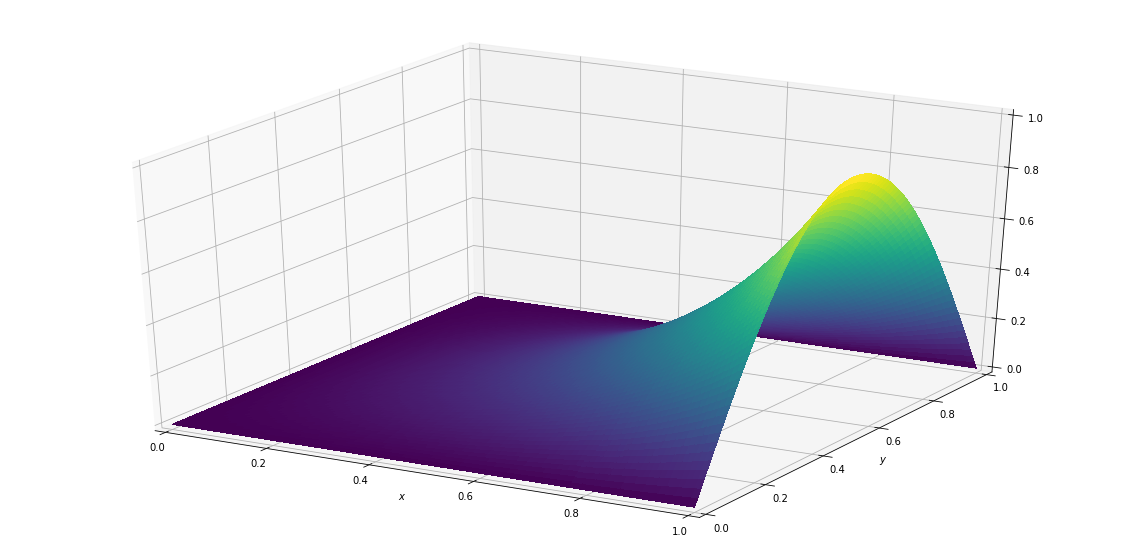

In [22]:
#Plot analytic
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x_space, y_space)
surf = ax.plot_surface(X, Y, analytic_surface, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

(0, 1)

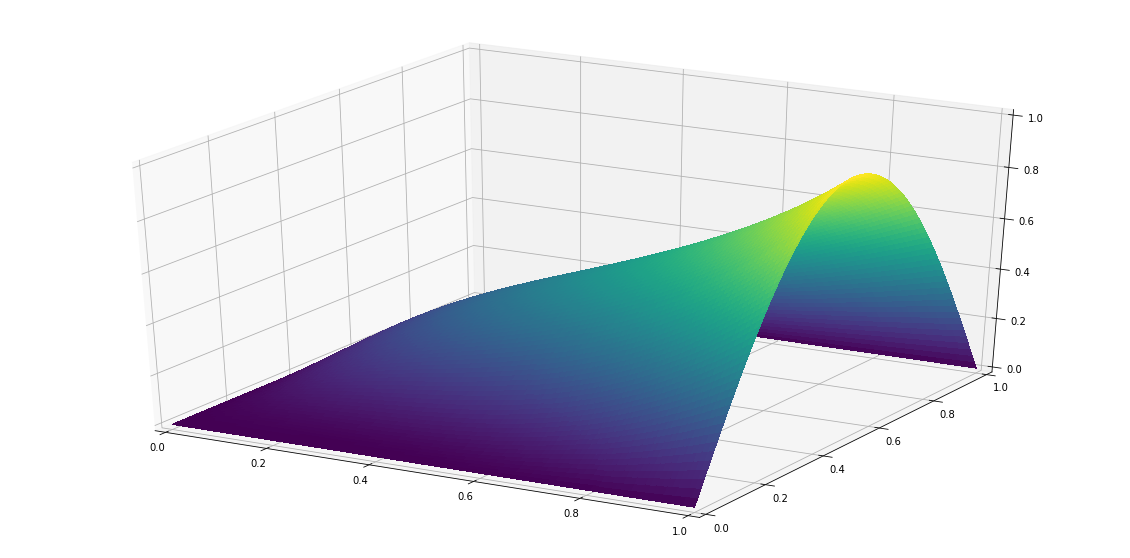

In [29]:
# Plot NN
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x_space, y_space)
surf = ax.plot_surface(X, Y, neural_surface, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

In [24]:
l = analytic_surface - neural_surface

In [26]:
np.sum(l**2) # Error in functions...?

198.61847745602196